## (Re)Load packages

In [172]:
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload
from pathlib import Path

import qcodes as qc
from qcodes.dataset.sqlite.database import connect

import dataAnalysis.spin_qubits.magnetic_field
import dataAnalysis.spin_qubits.single_shot

reload(dataAnalysis)
reload(dataAnalysis.spin_qubits.magnetic_field)
reload(dataAnalysis.spin_qubits.single_shot)


from dataAnalysis.spin_qubits.magnetic_field import BFieldInPlaneAngleSweep, GTensorCharacterization
from dataAnalysis.spin_qubits.single_shot import SingleShotMeasurement


cm = 1/2.54

## Data

In [3]:
data_folder = Path("../Data/")

db_path = data_folder / "2025_10_28_QT929_HYV1S1_hy3_combined_OPX.db"


connection = connect(db_path)
exp = qc.load_experiment(1, conn=connection)

run_id_single_shot_g = 633
run_id_single_shot_e = 632

run_id_ST_oscillations = 183


## Single-shot measurements

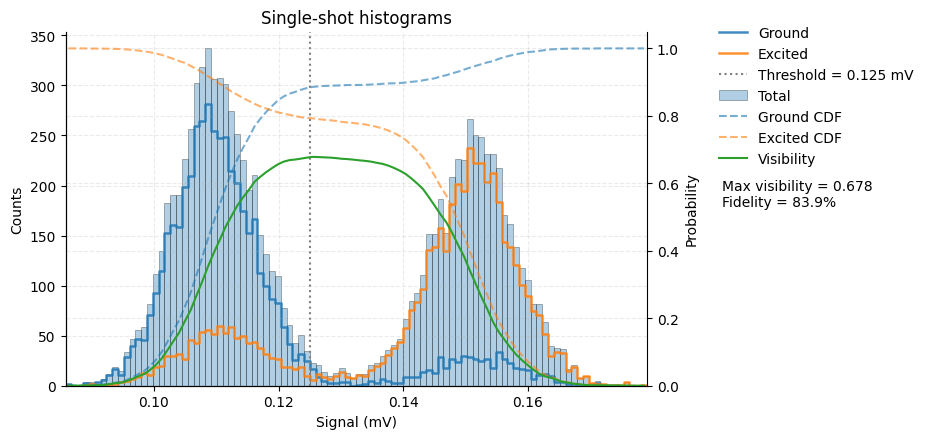

In [4]:
ssm = SingleShotMeasurement(exp=exp, run_id=[run_id_single_shot_g, run_id_single_shot_e])
ssm.build_histogram_from_time_trace(num_bins=100)
fig, ax = ssm.plot_histograms(type='stacked', signal_unit='mV', plot_CDF=True)

After running `ssm.build_histogram_from_time_trace(...)`, `ssm` has `ss.histogram`, which is a `Histogram` object. Such ojbect has the following attributes:
- `counts_g`
- `counts_e`
- `counts_tot`
- `edges`
- `left_edges`
- `bin_width`
- `bin_centers`
  
Running `sss.histogram.compute_visibility()` calculates the CDFs, the visibility, the threshold voltage and the fidelity. This is done automatically if one runs `ssm.plot_histograms(..., plot_CDF=True)`. Then, `ssm.histogram` witll contain the additional following attributes:
- `visibility_array`, the visibility for each signal value
- `max_visibility`
- `threshold`, always in the original measurement units
- `fidelity`

Examples of the other plotting options:

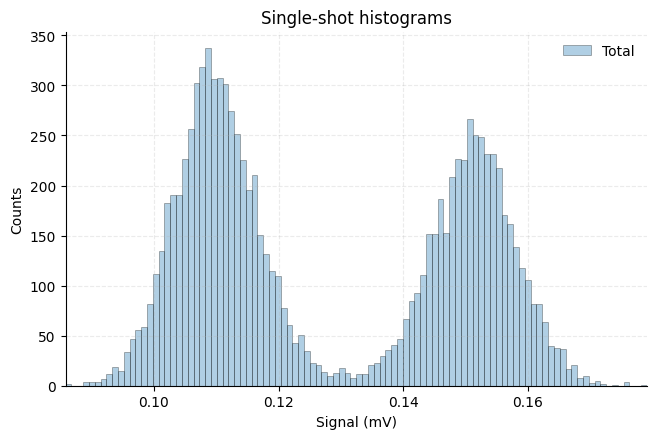

In [5]:
fig, ax = ssm.plot_histograms(type='stacked_only', signal_unit='mV')

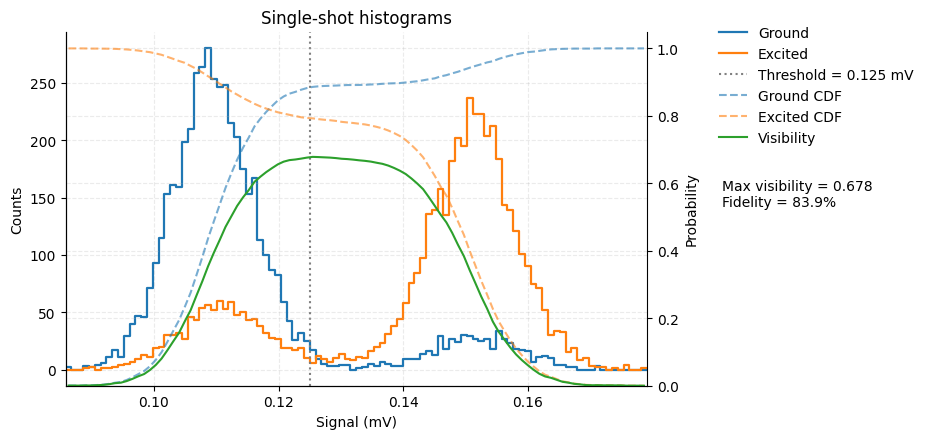

In [6]:
fig, ax = ssm.plot_histograms(type='overlay', signal_unit='mV', plot_CDF=True)

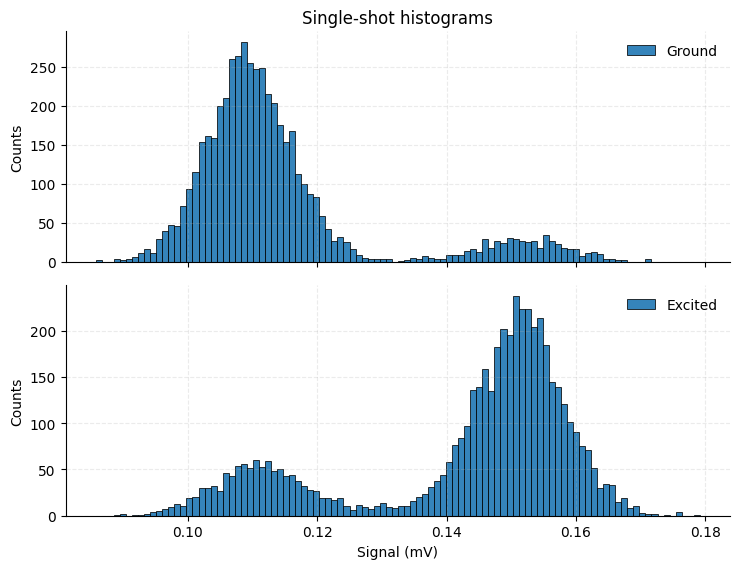

In [7]:
fig, ax = ssm.plot_histograms(type='separate', signal_unit='mV')

# Magnetic field measurements

### Load an in-plane angle sweep
This works both for one single dataset, and also for multiple datasets to concatenate. In the first case, provide a single integer value to `run_id`, in the second case provide a list `[first_run_id, last_run_id]`.
Now the DataSet class has a new method `normalize_from_average()` to normalize using the average along a certain axis (axis 0 is the default).

([<Figure size 640x480 with 2 Axes>],
 [<Axes: title={'center': 'Run #[3851, 3923], Experiment Qubit_experiments'}, xlabel='In_plane_angle (Deg)', ylabel='drive_frequency_axis0 (MHz)'>],
 [<matplotlib.colorbar.Colorbar at 0x1c62529d220>])

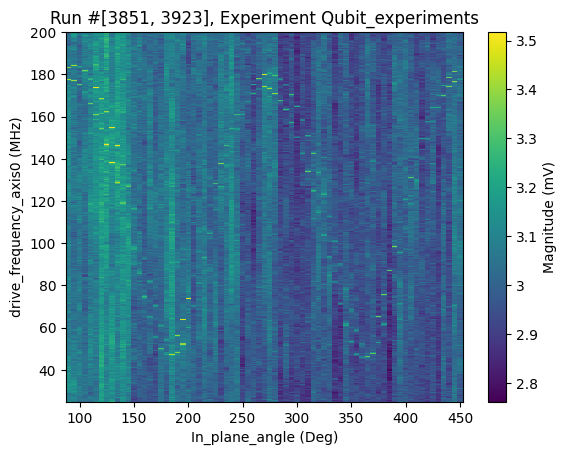

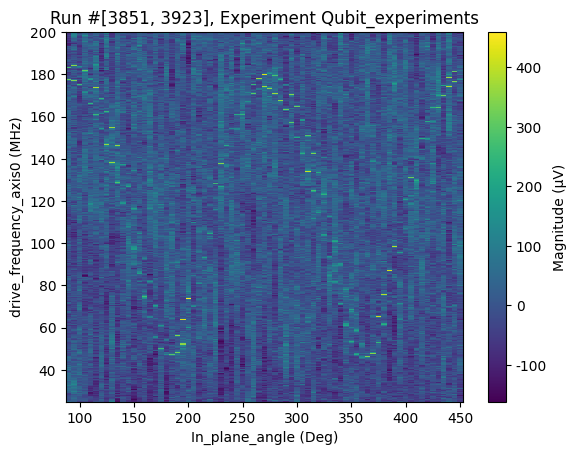

In [55]:
phi_array = np.arange(90, 455, 5)
ds = BFieldInPlaneAngleSweep(exp, [3851,3923], B_in_mag=30e-3, angle_values=phi_array)  # default B_out is assumed to be zero, but can be passed otherwise
ds.plot_2D(['param_0'])
ds.normalize_data_from_average()
ds.plot_2D(['param_0_normalized'])


The class `BFieldInPlaneAngleSweep` has the method `find_resonances` to find two resonance peaks for each angle value. This function can be used optionally with the option `follow_resonances=True` (the defaults is `False`), and then providing the search center frequency (`search_center`, in Hz) and the search span (`search_span`, in Hz) for the first angle value. Then, for each next angle value, the search center is adjusted to be in the center between the two previously found resonances, and the search span is kept the same.  

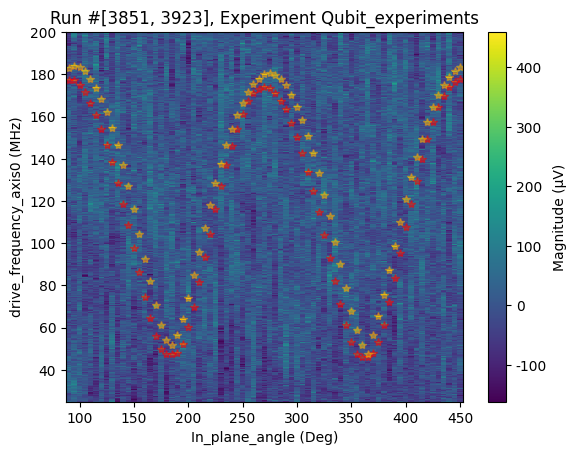

In [56]:
phi_array = np.arange(90, 455, 5)
ds = BFieldInPlaneAngleSweep(exp, [3851,3923], B_in_mag=30e-3, angle_values=phi_array)  # default B_out is assumed to be zero, but can be passed otherwise
ds.normalize_data_from_average()
ds.find_resonances(follow_resonances=True, search_center=180e6, search_span=45e6, min_separation=5)
# ds.find_resonances(follow_resonances=False, min_separation=5)

ds.plot_2D(['param_0_normalized'])
plt.plot(ds.angle, ds.results['f1'],  "*", c='red', alpha=0.5)
plt.plot(ds.angle, ds.results['f2'],  "*", c='orange', alpha=0.5)

### Extract g factors

C:\Users\acinapur\Documents\Git\dataAnalysis\dataAnalysis\spin_qubits\magnetic_field.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  elif angle_labels == 'xz':


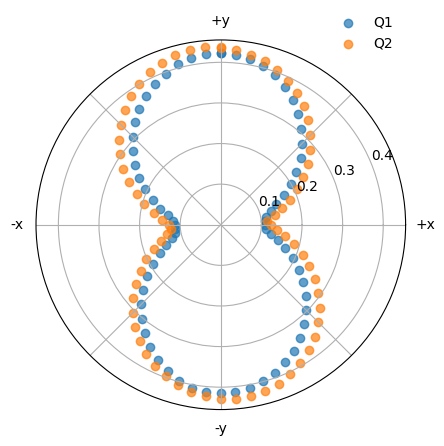

In [57]:
ds.extract_g_factors()
fig, ax, plots = ds.plot_g_factors(angle_labels='xy')

# g tensor fitting

First create the datasets. Each of them must have the g factors vs angle extracted. Here I manually adjust some of the resonances, don't mind it :)

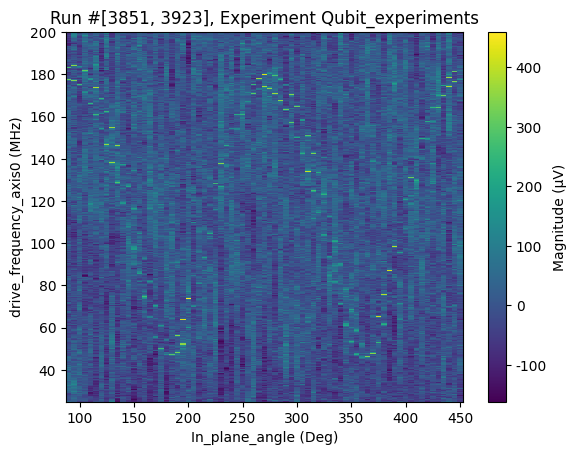

In [ ]:
# XY SWEEP
phi_array = np.arange(90, 455, 5)
xy_sweep = BFieldInPlaneAngleSweep(exp, [3851,3923], 30e-3, angle_values=phi_array)
xy_sweep.normalize_data_from_average()
xy_sweep.find_resonances(min_separation=10)
f1 = xy_sweep.results['f1']
f2 = xy_sweep.results['f2']
xy_sweep.results['f2'][13] = 104.06e6
xy_sweep.results['f1'][16] = 55.49e6
xy_sweep.results['f2'][16] = 70.32e6
xy_sweep.results['f1'][48] = 93.34e6
xy_sweep.results['f2'][48] = 112.55e6
xy_sweep.results['f2'][55] = 52.06e6
xy_sweep.extract_g_factors()


# YZ
phi_array = np.arange(-3, 4.2, 0.2)
yz_sweep = BFieldInPlaneAngleSweep(exp, run_id = [4081,4116], B_in_mag=30e-3, angle_values=phi_array)
yz_sweep.normalize_data_from_average(axis=0)
yz_sweep.find_resonances(min_separation=10)

yz_sweep.results['f1'][0] = 315.94e6
yz_sweep.results['f1'][1] = 302.39e6
yz_sweep.results['f1'][2] = 290.64e6
yz_sweep.results['f1'][16] = 155.75e6
yz_sweep.results['f2'][16] = 160.97e6
yz_sweep.results['f1'][17] = 150.17e6
yz_sweep.results['f1'][17] = 155.03e6
yz_sweep.results['f1'][21] = 137.72e6
yz_sweep.results['f2'][21] = 142.24e6
yz_sweep.results['f1'][27] = 152.46e6
yz_sweep.results['f2'][27] = 158.48e6
yz_sweep.results['f1'][28] = 157.97e6
yz_sweep.results['f2'][28] = 164.79e6
yz_sweep.results['f1'][29] = 164.70e6
yz_sweep.results['f2'][29] = 171.67e6
yz_sweep.results['f1'][30] = 171.94e6
yz_sweep.results['f2'][30] = 179.31e6
yz_sweep.results['f1'][31] = 179.68e6
yz_sweep.results['f2'][31] = 187.37e6
yz_sweep.results['f1'][35] = 215.77e6
yz_sweep.results['f2'][35] = 224.85e6
yz_sweep.extract_g_factors()

phi_array = np.arange(3, -4.2, -0.2)
xz_sweep = BFieldInPlaneAngleSweep(exp, run_id = [3980,4015], B_in_mag=30e-3, angle_values=phi_array)
xz_sweep.normalize_data_from_average(axis=0)
xz_sweep.find_resonances(min_separation=10)

xz_sweep.results['f2'][20] = 52.86e6
xz_sweep.results['f1'][35] = 218.60e6
xz_sweep.extract_g_factors();

Now let's create the class for fitting the g tensor: `GTensorCharacterization`. You can then provide in-plane sweep measurements to the class using the method `add_measurement`. These measurements then will be used for fitting.

In [176]:
gtc = GTensorCharacterization()
gtc.add_measurement(xy_sweep, 'xy')
gtc.add_measurement(yz_sweep, 'yz')
gtc.add_measurement(xz_sweep, 'xz')

C:\Users\acinapur\Documents\Git\dataAnalysis\dataAnalysis\spin_qubits\magnetic_field.py:324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_polar(angles_rad, g_fitted, style='line', fig=fig, ax=ax, label='fit', color='k', plot_legend=False)
C:\Users\acinapur\Documents\Git\dataAnalysis\dataAnalysis\spin_qubits\magnetic_field.py:357: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_polar(angles_rad, g_fitted, style='line', fig=fig, ax=ax, label='fit', color='k', plot_legend=False)
C:\Users\acinapur\Documents\Git\dataAnalysis\dataAnalysis\spin_qubits\magnetic_field.py:389: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_polar(angles_rad, g_fitted, style='line', fig=fig, ax=ax, label='fit', color='k', plot_legend=False)


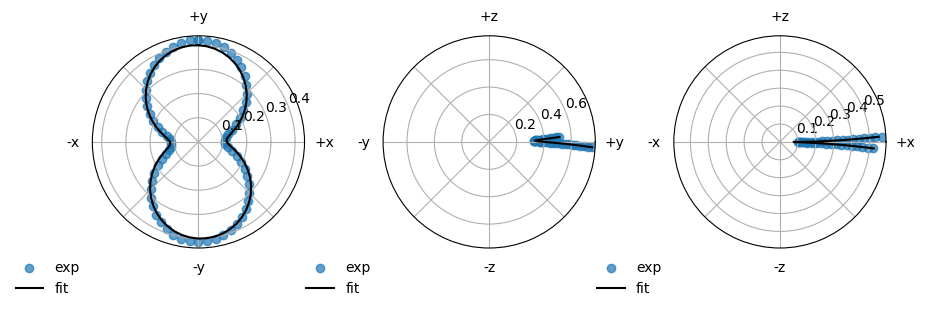

In [177]:
gtc.fit_g_tensor(qubit=1, do_plots=True)